## Example for LOO-PIT, K-hat and ELPD difference plots

In [1]:
%load_ext watermark
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

from hierarchical_bayes_nmr_validation import *

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")

In [3]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "1UBQ"
protein2 = '1D3Z'
bmrb_code = '6457'
marker = 'x'
samples = 2000

In [4]:
# CS data is collected for every protein in a single dataframe
dataframe_ubq = get_biomolecular_data(protein1, bmrb_code)
dataframe_d3z = get_biomolecular_data(protein2, bmrb_code)

C:\Users\User\Documents\Agustina\Hierarchical-Bayes-NMR-Validation\cheshift\_cheshift.py:660: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
C:\Users\User\Documents\Agustina\Hierarchical-Bayes-NMR-Validation\cheshift\_cheshift.py:660: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [ ]:
# run hierarchical bayesian linear regression for each protein 
dataframe_ubq, trace_ubq, pps_ubq = hierarchical_reg_target(dataframe_ubq, samples=samples)
dataframe_d3z, trace_d3z, pps_d3z= hierarchical_reg_target(dataframe_d3z, samples=samples)

Loaded reference trace from data\trace_reference_structures.nc


C:\Users\User\Anaconda3\envs\val\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\User\Anaconda3\envs\val\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\User\Anaconda3\envs\val\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\User\Anaconda3\envs\val\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3035 seconds.


Loaded reference trace from data\trace_reference_structures.nc


C:\Users\User\Anaconda3\envs\val\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\User\Anaconda3\envs\val\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\User\Anaconda3\envs\val\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\User\Anaconda3\envs\val\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

# LOO

In [ ]:
# as the variables were centered before running the linear regression, the following variables will be used to reverse it
_, _, reference_dataframe = load_data()
mean_teo = reference_dataframe["ca_teo"].mean()
mean_exp = reference_dataframe["ca_exp"].mean()
std_teo = reference_dataframe["ca_teo"].std()
std_exp = reference_dataframe["ca_exp"].std()

In [ ]:
# build an inference data object for each structure
idata_ubq = az.from_pymc3(trace_ubq, posterior_predictive={"cheshift":pps_ubq})
idata_ubq.observed_data['cheshift'] = idata_ubq.observed_data['cheshift'] * std_exp + mean_exp

In [ ]:
idata_d3z = az.from_pymc3(trace_d3z, posterior_predictive={"cheshift":pps_d3z})
idata_d3z.observed_data['cheshift'] = idata_d3z.observed_data['cheshift'] * std_exp + mean_exp

In [ ]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_d3z, y="cheshift", legend=False, ax=ax[0])
az.plot_loo_pit(idata_ubq, y="cheshift", legend=False, ax=ax[1], color='purple')
ax[0].set_title(protein2)
ax[1].set_title(protein1)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png")

# Khat

In [ ]:
# compute LOO separately
loo_ubq = az.loo(trace_ubq, pointwise=True)
loo_d3z = az.loo(trace_d3z, pointwise=True)

In [ ]:
# Plot K-hat
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_d3z, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_ubq, hlines_kwargs={"alpha":0}, ax=ax[1])

da_d3z = dataframe_d3z.res[loo_d3z.pareto_k.values > 0.7]
xs_d3z = da_d3z.index.values + 1
text_d3z = [a + " " + str(b) for a, b in zip(da_d3z, xs_d3z)]
ys_d3z = loo_d3z.pareto_k[loo_d3z.pareto_k > 0.7].values

for tx, x, y in zip(text_d3z, xs_d3z, ys_d3z):
    ax[0].annotate(tx, (x + 0.5 - dataframe_d3z.index[0], y))
    
da_ubq = dataframe_ubq.res[loo_ubq.pareto_k.values > 0.7]
xs_ubq = da_ubq.index.values +1
text_ubq = [a + " " + str(b) for a, b in zip(da_ubq, xs_ubq)]
ys_ubq = loo_ubq.pareto_k[loo_ubq.pareto_k > 0.7].values

for tx, x, y in zip(text_ubq, xs_ubq, ys_ubq):
    ax[1].annotate(tx, (x + 0.5 - dataframe_ubq.index[0], y))

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_xticks([-1, 8, 18, 28, 38, 48, 58, 68]) for i in range(len(ax))]
[ax[i].set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70']) for i in range(len(ax))]

[ax[i].set_title(protein) for i, protein in enumerate([protein2, protein1])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png")

# ELPD

In [ ]:
# compute ELPD difference
loo_ubq = az.loo(trace_ubq, pointwise=True).loo_i.values
loo_d3z = az.loo(trace_d3z, pointwise=True).loo_i.values
elpd = loo_d3z - loo_ubq

C:\Users\User\Anaconda3\envs\val\lib\site-packages\arviz\stats\stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\User\Anaconda3\envs\val\lib\site-packages\arviz\stats\stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\User\Anaconda3\envs\val\lib\site-packages\arviz\plots\bac

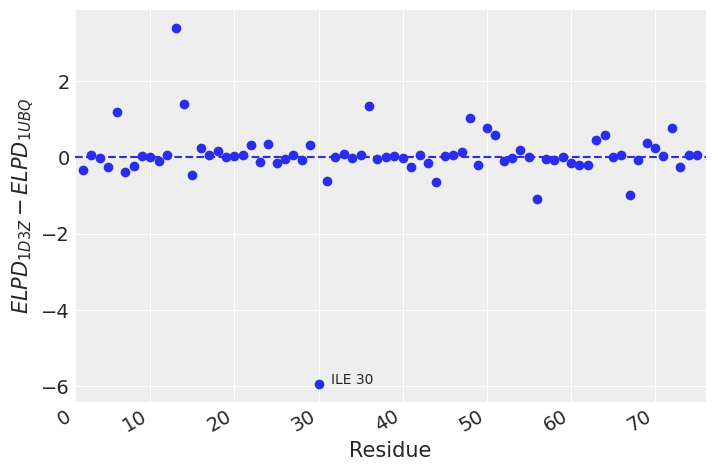

In [16]:
# plot ELPD difference
ax = az.plot_elpd({"1D3Z": idata_d3z, "1UBQ": idata_ubq}, xlabels=True)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel('$ELPD_{1D3Z}-ELPD_{1UBQ}$')
ax.set_xlim(1, len(dataframe_ubq))
ax.set_xticks([-1, 8, 18, 28, 38, 48, 58, 68])
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70'])
ax.set_title('')
da_ubq_1 = dataframe_ubq.res[elpd > 4]
da_ubq_2 = dataframe_ubq.res[elpd < -4]
da_ubq = pd.concat([da_ubq_1, da_ubq_2])
xs_ubq = da_ubq.index.values+1
text_ubq = [a + " " + str(b) for a, b in zip(da_ubq, xs_ubq)]
ys_ubq = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text_ubq, xs_ubq, ys_ubq):
    ax.annotate(tx, (x + 0.5 - dataframe_ubq.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight");

In [17]:
%watermark -v -m -p numpy,matplotlib,pymc3,arviz

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

numpy     : 1.20.1
matplotlib: 3.3.4
pymc3     : 3.11.0
arviz     : 0.11.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

